In [3]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/yasserhessein/dataset-alzheimer/versions/1"
print("Contents of dataset directory:")
print(os.listdir(dataset_path))


Contents of dataset directory:
['Alzheimer_s Dataset']


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserhessein/dataset-alzheimer")

print("Path to dataset files:", path)

100%|██████████| 34.1M/34.1M [00:00<00:00, 68.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yasserhessein/dataset-alzheimer/versions/1


In [4]:
train_dir = "/root/.cache/kagglehub/datasets/yasserhessein/dataset-alzheimer/versions/1/Alzheimer_s Dataset/train"
test_dir = "/root/.cache/kagglehub/datasets/yasserhessein/dataset-alzheimer/versions/1/Alzheimer_s Dataset/test"


In [5]:
import os

base_dir = "/root/.cache/kagglehub/datasets/yasserhessein/dataset-alzheimer/versions/1/Alzheimer_s Dataset"
print("Contents of Alzheimer_s Dataset directory:")
print(os.listdir(base_dir))

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

print("Train directory contents:", os.listdir(train_dir))
print("Test directory contents:", os.listdir(test_dir))


Contents of Alzheimer_s Dataset directory:
['train', 'test']
Train directory contents: ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
Test directory contents: ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Corrected paths
train_dir = "/root/.cache/kagglehub/datasets/yasserhessein/dataset-alzheimer/versions/1/Alzheimer_s Dataset/train"
test_dir = "/root/.cache/kagglehub/datasets/yasserhessein/dataset-alzheimer/versions/1/Alzheimer_s Dataset/test"

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 2
CLASSES = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Build Model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASSES), activation='softmax')  # 4 classes
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

# Evaluate Model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Save Model
model.save("alzheimer_detection_model_vgg19.h5")


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 4587s 28s/step - accuracy: 0.4033 - loss: 1.2911 - val_accuracy: 0.5004 - val_loss: 1.0316
Epoch 2/2
161/161 ━━━━━━━━━━━━━━━━━━━━ 4566s 28s/step - accuracy: 0.4619 - loss: 1.0898 - val_accuracy: 0.5004 - val_loss: 1.0298
33/40 ━━━━━━━━━━━━━━━━━━━━ 2:37 22s/step - accuracy: 0.5026 - loss: 1.0373

Found 1279 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 931s 23s/step


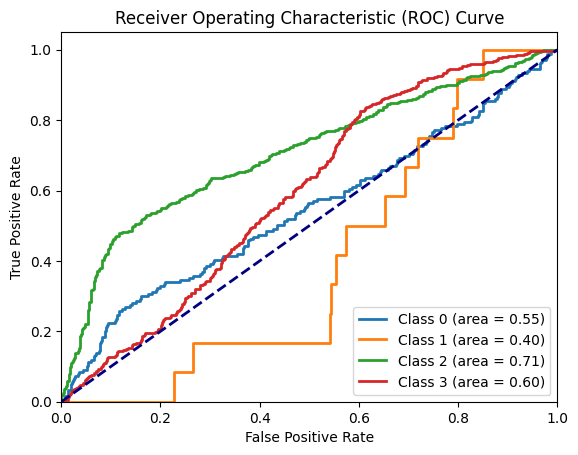

F1 Score (Macro-average): 0.1668


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# Load the trained model
model = load_model("alzheimer_detection_model_vgg19.h5")

# Data preparation (no augmentation for testing)
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for ROC curve as we need the true labels in order
)

# Get the true labels and the predicted probabilities
y_true = test_generator.classes
y_pred = model.predict(test_generator, verbose=1)

# Binarize the true labels for multi-class ROC (one-vs-rest)
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(len(lb.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {lb.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute F1 score (Macro-average)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class predictions
f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f'F1 Score (Macro-average): {f1:.4f}')


Saving OIP.jpg to OIP.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Non Demented


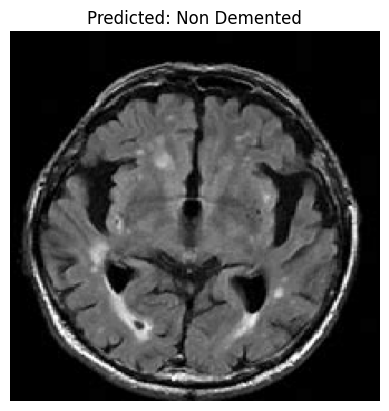

In [2]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Upload file
uploaded = files.upload()

# Retrieve the uploaded file path
file_path = next(iter(uploaded))  # Works (iter = 0, width = 1500)

# Load the trained model
model = load_model("alzheimer_detection_model_vgg19.h5")

# Preprocess the uploaded image
img = image.load_img(file_path, target_size=(224, 224))  # Resize the image
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale the image to [0, 1]

# Make prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the highest probability

# Define class labels
class_labels = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]

# Print the predicted class
print(f"Predicted Class: {class_labels[predicted_class]}")

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')  # Hide axis
plt.show()
